# Crytocurrency price forecasting using Neural Networks
### Author : Prafulla Ranjan Dash

In [1]:
#! pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R_squared
from sklearn.metrics import explained_variance_score as EVS

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import OrderedDict

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path = 'D:/USMS/UChicago/STUDIES/Autumn 2020/MSCA 31009 2 Machine Learning & Predictive Analytics/Final Project/data/'

In [4]:
# importing the data
BTC_USD = pd.read_csv(data_path+'BTC-USD.csv')
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,23-11-15,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
1,24-11-15,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2,25-11-15,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
3,26-11-15,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
4,27-11-15,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [5]:
# importing the data
XRP_USD = pd.read_csv(data_path+'XRP-USD.csv')
XRP_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-23,0.004269,0.004351,0.004237,0.004288,0.004288,314451
1,2015-11-24,0.004288,0.004288,0.004201,0.004242,0.004242,197940
2,2015-11-25,0.004242,0.004325,0.004228,0.004318,0.004318,197356
3,2015-11-26,0.004317,0.004435,0.004227,0.004291,0.004291,400520
4,2015-11-27,0.004276,0.004304,0.004229,0.004276,0.004276,199790


In [6]:
# importing the data
ETH_USD = pd.read_csv(data_path+'ETH-USD.csv')
ETH_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-26,0.863273,0.903643,0.804360,0.884183,0.884183,947473
1,2015-11-27,0.882100,0.900051,0.860695,0.867951,0.867951,403813
2,2015-11-28,0.868102,0.929293,0.862122,0.915703,0.915703,462464
3,2015-11-29,0.914144,0.914153,0.860533,0.878614,0.878614,448358
4,2015-11-30,0.879951,0.895054,0.847696,0.873119,0.873119,784439


Visualizing the data

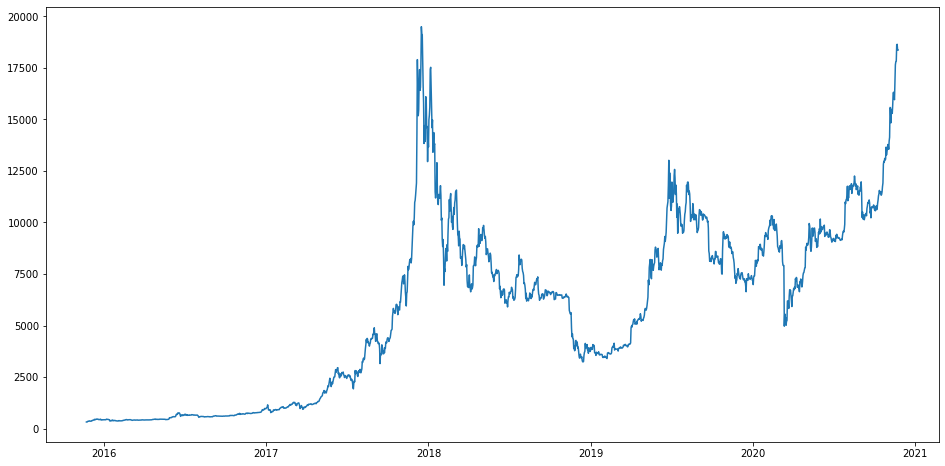

In [7]:
#setting index as date
BTC_USD['Date'] = pd.to_datetime(BTC_USD.Date,format='%d-%m-%y')
BTC_USD.index = BTC_USD['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(BTC_USD['Adj Close'], label='Close Price history')
plt.show()

Linear Regression is not designed to capture the short term dynamics or the autocorrelations which are present in this sequential data. It is more designed to look at the data globally and capture the global trend. We need a model that is able to capture the short term dynamics and short term dependencies within our dataset.

In the world of Neural Networks, we have something called **Recurrent Neural Networks** which is designed to capture these dependencies. Let's apply this and see how it performs in predicting the Bitcoin prices

In [8]:
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-11-23,2015-11-23,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
2015-11-24,2015-11-24,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2015-11-25,2015-11-25,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
2015-11-26,2015-11-26,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
2015-11-27,2015-11-27,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [9]:
BTC_USD.reset_index(drop=True,inplace=True)

In [10]:
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-23,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
1,2015-11-24,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2,2015-11-25,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
3,2015-11-26,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
4,2015-11-27,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [11]:
BTC_USD.shape

(1828, 7)

### Making the data ready for feeding to the RNNs

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# fix random seed for reproducibility
np.random.seed(5)

In [14]:
# take adjusted close price column
bitcoin_y = BTC_USD['Adj Close'].values
bitcoin_dataset=bitcoin_y.reshape(-1, 1)

In [15]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_dataset = scaler.fit_transform(bitcoin_dataset)

In [16]:
# split into train and test sets, 25% test data, 75% training data
bitcoin_train_size = int(len(bitcoin_dataset) * 0.75)
bitcoin_test_size = len(bitcoin_dataset) - bitcoin_train_size
bitcoin_train, bitcoin_test = bitcoin_dataset[0:bitcoin_train_size,:], bitcoin_dataset[bitcoin_train_size:len(bitcoin_dataset),:]

In [17]:
# reshape into X=t and Y=t+1, timestep 240
look_back = 240
bitcoin_trainX, bitcoin_trainY = create_dataset(bitcoin_train, look_back)
bitcoin_testX, bitcoin_testY = create_dataset(bitcoin_test, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
bitcoin_trainX = np.reshape(bitcoin_trainX, (bitcoin_trainX.shape[0], 1, bitcoin_trainX.shape[1]))
bitcoin_testX = np.reshape(bitcoin_testX, (bitcoin_testX.shape[0], 1, bitcoin_testX.shape[1]))

### Simple RNN

In [19]:
# using 10 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(64,activation = 'relu',return_sequences= True))
model_RNN.add(SimpleRNN(8,activation = 'relu'))
model_RNN.add(Dense(128,activation = 'relu'))
model_RNN.add(Dense(1))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.0948 - mean_squared_error: 0.09 - 0s 5ms/step - loss: 0.0976 - mean_squared_error: 0.0976
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.0650 - mean_squared_error: 0.06 - 0s 4ms/step - loss: 0.0394 - mean_squared_error: 0.0394
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.0125 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.0146 - mean_squared_error: 0.01 - 0s 8ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 7/10
5/5 [==============================] - ET

In [20]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [21]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.07
Test RMSE for the bitcoin LSTM: 0.10


We see that using 10 epochs resulted in reasonablly good predictions. But there is a hint of overfitting here as the train RMSE is less than test RMSE. Let's try with more epochs

In [22]:
# using 100 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(64,activation = 'relu',return_sequences= True))
model_RNN.add(SimpleRNN(8,activation = 'relu'))
model_RNN.add(Dense(128,activation = 'relu'))
model_RNN.add(Dense(1))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN_fitted = model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1118 - mean_squared_error: 0.11 - 0s 4ms/step - loss: 0.1054 - mean_squared_error: 0.1054
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0887 - mean_squared_error: 0.08 - 0s 4ms/step - loss: 0.0834 - mean_squared_error: 0.0834
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0714 - mean_squared_error: 0.07 - 0s 4ms/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0260 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0292 - mean_squared_error: 0.0292
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0239 - mean_squared_error: 0.0239
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 7/100
5/5 [=============================

Epoch 51/100
5/5 [==============================] - ETA: 0s - loss: 8.9371e-04 - mean_squared_error: 8.9371e- - 0s 3ms/step - loss: 7.9340e-04 - mean_squared_error: 7.9340e-04
Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 9.3922e-04 - mean_squared_error: 9.3922e- - 0s 4ms/step - loss: 8.1914e-04 - mean_squared_error: 8.1914e-04
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 5.9312e-04 - mean_squared_error: 5.9312e- - 0s 4ms/step - loss: 7.5488e-04 - mean_squared_error: 7.5488e-04
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 6.0857e-04 - mean_squared_error: 6.0857e- - 0s 4ms/step - loss: 7.2910e-04 - mean_squared_error: 7.2910e-04
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 6.7915e-04 - mean_squared_error: 6.7915e- - 0s 4ms/step - loss: 7.1879e-04 - mean_squared_error: 7.1879e-04
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 5.5039e-04 - mean_squared_error: 5.5039e- - 0s 5ms/s

5/5 [==============================] - ETA: 0s - loss: 7.4591e-04 - mean_squared_error: 7.4591e- - 0s 5ms/step - loss: 4.7493e-04 - mean_squared_error: 4.7493e-04
Epoch 98/100
5/5 [==============================] - ETA: 0s - loss: 4.3273e-04 - mean_squared_error: 4.3273e- - 0s 4ms/step - loss: 5.2717e-04 - mean_squared_error: 5.2717e-04
Epoch 99/100
5/5 [==============================] - ETA: 0s - loss: 3.9349e-04 - mean_squared_error: 3.9349e- - 0s 4ms/step - loss: 4.5842e-04 - mean_squared_error: 4.5842e-04
Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 3.2973e-04 - mean_squared_error: 3.2973e- - 0s 4ms/step - loss: 4.6694e-04 - mean_squared_error: 4.6694e-04


In [23]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [24]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.02
Test RMSE for the bitcoin LSTM: 0.07


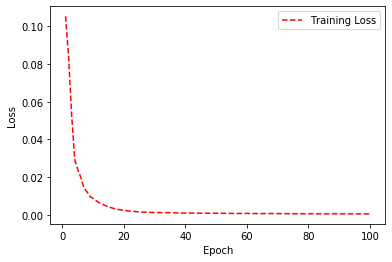

In [25]:
# Get training loss histories
training_loss = model_RNN_fitted.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Here, we can see that the loss is decreasing very rapidly initially, but as it is closer to the optimal point (zero), it's rate of reduction is slowing down

We now see that even after increasing the number of epochs, the performance of the simple RNN model improved just a little bit. Also, there is still some overfitting. The RNNS are also prone to **Vanishing Gradient Problem**, but here it is not visible even though there are many layers.

So, to solve the Vanishing Gradient problem in general, we can use **LSTM (Long Short Term Memory)**

### LSTM - Long Short Term Memory

In [26]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
bitcoin_lstm_model_fitted = bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1666 - mean_squared_error: 0.16 - 0s 5ms/step - loss: 0.0736 - mean_squared_error: 0.0736
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0293 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0354 - mean_squared_error: 0.0354
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0294 - mean_squared_error: 0.02 - 0s 6ms/step - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0180 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 58/100
5/5 [==============================] - E

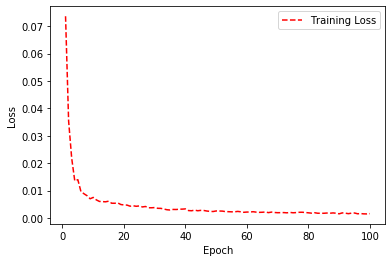

In [27]:
# loss function for LSTM model
# Get training loss histories
training_loss = bitcoin_lstm_model_fitted.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [28]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [29]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.03
Test RMSE for the bitcoin LSTM: 0.06


So, using LSTM we have seen **marked improvement** in the performance of the model and it is now making much **better predictions**. The model is fitting very well as the gap between the train and test error is very less.

Also, here we are following the principle of **Exploitation** of Machine learning where we are using the same hyperparameters for more number of epochs for getting the best results.

In [30]:
# invert predictions
bitcoin_trainPredict_reverted = scaler.inverse_transform(bitcoin_trainPredict)
bitcoin_trainY_reverted = scaler.inverse_transform([bitcoin_trainY])
bitcoin_testPredict_reverted = scaler.inverse_transform(bitcoin_testPredict)
bitcoin_testY_reverted = scaler.inverse_transform([bitcoin_testY])

In [31]:
# shift train predictions for plotting
bitcoin_trainPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_trainPredictPlot[:, :] = np.nan
bitcoin_trainPredictPlot[look_back:len(bitcoin_trainPredict_reverted)+look_back, :] = bitcoin_trainPredict_reverted

In [32]:
# shift test predictions for plotting
bitcoin_testPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_testPredictPlot[:, :] = np.nan
bitcoin_testPredictPlot[len(bitcoin_trainPredict_reverted)+(look_back*2)+1:len(bitcoin_dataset)-1, :] = bitcoin_testPredict_reverted

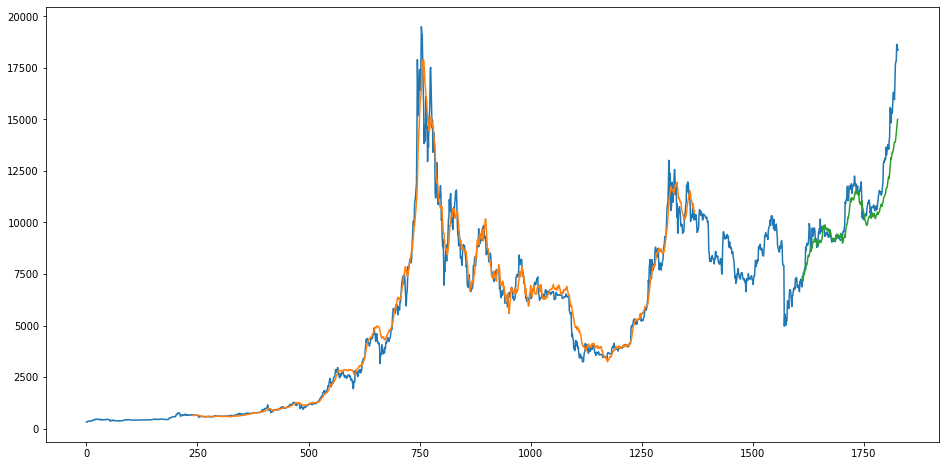

In [33]:
# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(bitcoin_dataset))
plt.plot(bitcoin_trainPredictPlot)
plt.plot(bitcoin_testPredictPlot)

Now, let's try using a different optimizer - **Stochastic Gradient Descent** for LSTM

In [34]:
# create and fit the LSTM network, optimizer=SGD, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='SGD',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.2002 - mean_squared_error: 0.20 - 0s 4ms/step - loss: 0.1776 - mean_squared_error: 0.1776
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1378 - mean_squared_error: 0.13 - 0s 5ms/step - loss: 0.1139 - mean_squared_error: 0.1139
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0830 - mean_squared_error: 0.08 - 0s 4ms/step - loss: 0.0774 - mean_squared_error: 0.0774
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0673 - mean_squared_error: 0.06 - 0s 5ms/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0477 - mean_squared_error: 0.04 - 0s 5ms/step - loss: 0.0424 - mean_squared_error: 0.0424
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0398 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0122 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0124 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.01 - 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 58/100
5/5 [==============================] - E

In [35]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [36]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.08
Test RMSE for the bitcoin LSTM: 0.12


We see **Stochastic Gradient Descent** is not that effective as **ADAM** when it comes to optimizing the cost function

Using a different optimizer - **AdaGrad**

In [37]:
# create and fit the LSTM network, optimizer=Adagrad, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='Adagrad',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1064 - mean_squared_error: 0.10 - 0s 6ms/step - loss: 0.0968 - mean_squared_error: 0.0968
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0881 - mean_squared_error: 0.08 - 0s 4ms/step - loss: 0.0828 - mean_squared_error: 0.0828
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0725 - mean_squared_error: 0.07 - 0s 5ms/step - loss: 0.0723 - mean_squared_error: 0.0723
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0703 - mean_squared_error: 0.07 - 0s 4ms/step - loss: 0.0636 - mean_squared_error: 0.0636
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0600 - mean_squared_error: 0.06 - 0s 4ms/step - loss: 0.0564 - mean_squared_error: 0.0564
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0558 - mean_squared_error: 0.05 - 0s 4ms/step - loss: 0.0499 - mean_squared_error: 0.0499
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0169 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0128 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0113 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 58/100
5/5 [==============================] - E

In [38]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [39]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.09
Test RMSE for the bitcoin LSTM: 0.08


**AdaGrad** also not performing that well, when compared to **ADAM**

### Hyperparameter tuning using Optuna

Now, let's try to tune our hyperparameters for the LSTM model to get the optimal parameters using **Optuna**

In [40]:
# defining the objective function
def objective(trial):
    units = trial.suggest_int('units', 2, 25)
    rate = trial.suggest_int('rate', 0.1, 0.9)
    #epochs = trial.suggest_int('epochs', 10, 100)
    bitcoin_lstm_model = Sequential()
    bitcoin_lstm_model.add(LSTM(units, input_shape=(1, look_back)))
    bitcoin_lstm_model.add(Dropout(rate))
    bitcoin_lstm_model.add(Dense(1))
    bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)
    # make predictions
    bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
    bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)
    
    bitcoin_trainScore = round(np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict)),2)
    bitcoin_testScore = round(np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict)),2)
    return bitcoin_testScore

Here, we have created the **study** object which contains all the information about the required parameter space.

In [41]:
# creating study object
study = optuna.create_study(direction='minimize')

# calling the optimize function
study.optimize(objective, n_trials=10)

[I 2020-12-08 22:19:56,889] A new study created in memory with name: no-name-86ad8b31-24f7-47ae-a6d5-c919993f191d


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1671 - mean_squared_error: 0.16 - 0s 3ms/step - loss: 0.1153 - mean_squared_error: 0.1153
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0499 - mean_squared_error: 0.04 - 0s 5ms/step - loss: 0.0357 - mean_squared_error: 0.0357
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0271 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0188 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0222 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0150 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-08 22:20:05,402] Trial 0 finished with value: 0.09 and parameters: {'units': 6, 'rate': 0}. Best is trial 0 with value: 0.09.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0649 - mean_squared_error: 0.06 - 0s 5ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0229 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0165 - mean_squared_error: 0.0165
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 7/100
5/5 [=============================

Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 9.6738e-04 - mean_squared_error: 9.6738e- - 0s 4ms/step - loss: 9.7215e-04 - mean_squared_error: 9.7215e-04
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 9.9964e-04 - mean_squared_error: 9.9964e- - 0s 4ms/step - loss: 9.4543e-04 - mean_squared_error: 9.4543e-04
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 9.5209e-04 - mean_squared_error: 9.5209e- - 0s 4ms/step - loss: 9.3345e-04 - mean_squared_error: 9.3345e-04
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 9.3560e-04 - mean_squared_error: 9.3560e-04
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 9.6222e-04 - mean_squared_error: 9.6222e-04
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 8.0682e-04 - mean_squared_error: 8.0682e- - 0s 4ms/step - loss: 9.09

Epoch 99/100
5/5 [==============================] - ETA: 0s - loss: 7.1091e-04 - mean_squared_error: 7.1091e- - 0s 5ms/step - loss: 6.0902e-04 - mean_squared_error: 6.0902e-04
Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 5.5809e-04 - mean_squared_error: 5.5809e- - 0s 4ms/step - loss: 6.0308e-04 - mean_squared_error: 6.0308e-04


[I 2020-12-08 22:20:14,362] Trial 1 finished with value: 0.06 and parameters: {'units': 19, 'rate': 0}. Best is trial 1 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1322 - mean_squared_error: 0.13 - 0s 4ms/step - loss: 0.0940 - mean_squared_error: 0.0940
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0393 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0248 - mean_squared_error: 0.0248
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0270 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0248 - mean_squared_error: 0.0248
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0169 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0156 - mean_squared_error: 0.0156
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-08 22:20:22,464] Trial 2 finished with value: 0.07 and parameters: {'units': 10, 'rate': 0}. Best is trial 1 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.03 - 0s 6ms/step - loss: 0.0248 - mean_squared_error: 0.0248
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0163 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 8.5673e-04 - mean_squared_error: 8.5673e-04
Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 5.4417e-04 - mean_squared_error: 5.4417e- - 0s 4ms/step - loss: 8.4971e-04 - mean_squared_error: 8.4971e-04
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 6.5526e-04 - mean_squared_error: 6.5526e- - 0s 4ms/step - loss: 8.3713e-04 - mean_squared_error: 8.3713e-04
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 8.6004e-04 - mean_squared_error: 8.6004e- - 0s 4ms/step - loss: 8.7410e-04 - mean_squared_error: 8.7410e-04
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 8.0620e-04 - mean_squared_error: 8.0620e- - 0s 4ms/step - loss: 8.4286e-04 - mean_squared_error: 8.4286e-04
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 6.9118e-04 - mean_squared_error: 6.9118e- - 0s 4ms/step - loss: 8.8894e-0

Epoch 98/100
5/5 [==============================] - ETA: 0s - loss: 9.5758e-04 - mean_squared_error: 9.5758e- - 0s 4ms/step - loss: 6.4276e-04 - mean_squared_error: 6.4276e-04
Epoch 99/100
5/5 [==============================] - ETA: 0s - loss: 8.2093e-04 - mean_squared_error: 8.2093e- - 0s 4ms/step - loss: 6.1272e-04 - mean_squared_error: 6.1272e-04
Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 4.4509e-04 - mean_squared_error: 4.4509e- - 0s 4ms/step - loss: 5.8330e-04 - mean_squared_error: 5.8330e-04


[I 2020-12-08 22:20:31,729] Trial 3 finished with value: 0.08 and parameters: {'units': 25, 'rate': 0}. Best is trial 1 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0320 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0239 - mean_squared_error: 0.0239
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0129 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 7/100
5/5 [=============================

Epoch 51/100
5/5 [==============================] - ETA: 0s - loss: 9.1827e-04 - mean_squared_error: 9.1827e- - 0s 4ms/step - loss: 8.5506e-04 - mean_squared_error: 8.5506e-04
Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 8.4548e-04 - mean_squared_error: 8.4548e- - 0s 4ms/step - loss: 8.2885e-04 - mean_squared_error: 8.2885e-04
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 8.2431e-04 - mean_squared_error: 8.2431e-04
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 8.2238e-04 - mean_squared_error: 8.2238e- - 0s 4ms/step - loss: 8.2806e-04 - mean_squared_error: 8.2806e-04
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 5.7906e-04 - mean_squared_error: 5.7906e- - 0s 4ms/step - loss: 8.0855e-04 - mean_squared_error: 8.0855e-04
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 8.2954e-04 - mean_squared_error: 8.2954e- - 0s 4ms/step - lo

Epoch 98/100
5/5 [==============================] - ETA: 0s - loss: 6.4616e-04 - mean_squared_error: 6.4616e- - 0s 4ms/step - loss: 5.8928e-04 - mean_squared_error: 5.8928e-04
Epoch 99/100
5/5 [==============================] - ETA: 0s - loss: 6.1818e-04 - mean_squared_error: 6.1818e- - 0s 4ms/step - loss: 5.9876e-04 - mean_squared_error: 5.9876e-04
Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 4.4297e-04 - mean_squared_error: 4.4297e- - 0s 4ms/step - loss: 6.0576e-04 - mean_squared_error: 6.0576e-04


[I 2020-12-08 22:20:40,608] Trial 4 finished with value: 0.07 and parameters: {'units': 17, 'rate': 0}. Best is trial 1 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0405 - mean_squared_error: 0.04 - 0s 5ms/step - loss: 0.0253 - mean_squared_error: 0.0253
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 8.3330e-04 - mean_squared_error: 8.3330e- - 0s 4ms/step - loss: 9.9590e-04 - mean_squared_error: 9.9590e-04
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 9.2280e-04 - mean_squared_error: 9.2280e- - 0s 4ms/step - loss: 9.7166e-04 - mean_squared_error: 9.7166e-04
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 8.6541e-04 - mean_squared_error: 8.6541e- - 0s 3ms/step - loss: 9.7301e-04 - mean_squared_error: 9.7301e-04
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 6.9311e-04 - mean_squared_error: 6.9311e- - 0s 4ms/step - loss: 9.4446e-04 - mean_squared_error: 9.4446e-04
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 7.3666e-04 - mean_squared_error: 7.3666e- - 0s 3ms/step - loss: 9.3279e-04 - mean_squared_error: 9.3279e-04
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 8.8539e-04 - mean_squared_error: 8.8539e- - 0s 4ms/step - loss: 9

Epoch 99/100
5/5 [==============================] - ETA: 0s - loss: 7.5242e-04 - mean_squared_error: 7.5242e- - 0s 4ms/step - loss: 6.4883e-04 - mean_squared_error: 6.4883e-04
Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 4.8120e-04 - mean_squared_error: 4.8120e- - 0s 4ms/step - loss: 6.3920e-04 - mean_squared_error: 6.3920e-04


[I 2020-12-08 22:20:49,721] Trial 5 finished with value: 0.06 and parameters: {'units': 8, 'rate': 0}. Best is trial 1 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0769 - mean_squared_error: 0.07 - 0s 5ms/step - loss: 0.0382 - mean_squared_error: 0.0382
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0239 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0241 - mean_squared_error: 0.0241
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0144 - mean_squared_error: 0.0144
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.00 - 0s 3ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-08 22:20:58,618] Trial 6 finished with value: 0.07 and parameters: {'units': 4, 'rate': 0}. Best is trial 1 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1234 - mean_squared_error: 0.12 - 0s 5ms/step - loss: 0.0658 - mean_squared_error: 0.0658
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0235 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0242 - mean_squared_error: 0.0242
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0258 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 8.9680e-04 - mean_squared_error: 8.9680e- - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013    
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 9.1364e-04 - mean_squared_error: 9.1364e- - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013    
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 58/100
5/5 [===========

Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 8.3603e-04 - mean_squared_error: 8.3603e- - 0s 6ms/step - loss: 7.7803e-04 - mean_squared_error: 7.7803e-04


[I 2020-12-08 22:21:08,434] Trial 7 finished with value: 0.08 and parameters: {'units': 15, 'rate': 0}. Best is trial 1 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1617 - mean_squared_error: 0.16 - 0s 5ms/step - loss: 0.0789 - mean_squared_error: 0.0789
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0309 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0399 - mean_squared_error: 0.0399
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0276 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 7/100
5/5 [=============================

Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 9.6887e-04 - mean_squared_error: 9.6887e- - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012    
Epoch 58/100
5/5 [==========

Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 9.9536e-04 - mean_squared_error: 9.9536e- - 0s 5ms/step - loss: 8.1349e-04 - mean_squared_error: 8.1349e-04


[I 2020-12-08 22:21:18,023] Trial 8 finished with value: 0.05 and parameters: {'units': 24, 'rate': 0}. Best is trial 8 with value: 0.05.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1842 - mean_squared_error: 0.18 - 0s 6ms/step - loss: 0.0930 - mean_squared_error: 0.0930
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0264 - mean_squared_error: 0.0264
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0355 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0189 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0189 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0131 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-08 22:21:26,620] Trial 9 finished with value: 0.07 and parameters: {'units': 13, 'rate': 0}. Best is trial 8 with value: 0.05.


In [42]:
# best test error
trial = study.best_trial
print('Best test error: {}'.format(trial.value))

Best test error: 0.05


In [43]:
# best hyperparameters
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'units': 24, 'rate': 0}


So, we saw that using **Optuna**, we got the best hyperparameters of **number of LSTM units** and **number of dropout nodes** as **19** and **0** respectively. Similarly, we can use this to tune other hyperparameters as well.

Let's try optimizing the number of **epochs** and **batch_size**

In [44]:
# defining the objective function
def objective(trial):
    units = trial.suggest_int('units', 2, 25)
    rate = trial.suggest_int('rate', 0.1, 0.9)
    epochs = trial.suggest_int('epochs', 10, 100)
    batch_size = trial.suggest_int('batch_size', 100, 300)
    bitcoin_lstm_model = Sequential()
    bitcoin_lstm_model.add(LSTM(units, input_shape=(1, look_back)))
    bitcoin_lstm_model.add(Dropout(rate))
    bitcoin_lstm_model.add(Dense(1))
    bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=epochs, batch_size=240, verbose=1)
    # make predictions
    bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
    bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)
    
    bitcoin_trainScore = round(np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict)),2)
    bitcoin_testScore = round(np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict)),2)
    return bitcoin_testScore

In [45]:
# creating study object
study = optuna.create_study(direction='minimize')

# calling the optimize function
study.optimize(objective, n_trials=10)

[I 2020-12-08 22:21:26,768] A new study created in memory with name: no-name-21a23f0f-8cfb-41b1-afb1-af350101be9b


Epoch 1/22
5/5 [==============================] - ETA: 0s - loss: 0.1369 - mean_squared_error: 0.13 - 0s 5ms/step - loss: 0.0884 - mean_squared_error: 0.0884
Epoch 2/22
5/5 [==============================] - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0277 - mean_squared_error: 0.0277
Epoch 3/22
5/5 [==============================] - ETA: 0s - loss: 0.0270 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0246 - mean_squared_error: 0.0246
Epoch 4/22
5/5 [==============================] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 5/22
5/5 [==============================] - ETA: 0s - loss: 0.0129 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 6/22
5/5 [==============================] - ETA: 0s - loss: 0.0125 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 7/22
5/5 [==============================] - ET

[I 2020-12-08 22:21:32,359] Trial 0 finished with value: 0.13 and parameters: {'units': 6, 'rate': 0, 'epochs': 22, 'batch_size': 137}. Best is trial 0 with value: 0.13.


Epoch 1/40
5/5 [==============================] - ETA: 0s - loss: 0.1259 - mean_squared_error: 0.12 - 0s 5ms/step - loss: 0.0707 - mean_squared_error: 0.0707
Epoch 2/40
5/5 [==============================] - ETA: 0s - loss: 0.0312 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 3/40
5/5 [==============================] - ETA: 0s - loss: 0.0273 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0217 - mean_squared_error: 0.0217
Epoch 4/40
5/5 [==============================] - ETA: 0s - loss: 0.0141 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 5/40
5/5 [==============================] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 6/40
5/5 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 7/40
5/5 [==============================] - ET

[I 2020-12-08 22:21:39,585] Trial 1 finished with value: 0.1 and parameters: {'units': 12, 'rate': 0, 'epochs': 40, 'batch_size': 211}. Best is trial 1 with value: 0.1.


Epoch 1/35
5/5 [==============================] - ETA: 0s - loss: 0.0586 - mean_squared_error: 0.05 - 0s 5ms/step - loss: 0.0296 - mean_squared_error: 0.0296
Epoch 2/35
5/5 [==============================] - ETA: 0s - loss: 0.0309 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 3/35
5/5 [==============================] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 4/35
5/5 [==============================] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 5/35
5/5 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 6/35
5/5 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 7/35
5/5 [==============================] - ET

[I 2020-12-08 22:21:46,517] Trial 2 finished with value: 0.08 and parameters: {'units': 21, 'rate': 0, 'epochs': 35, 'batch_size': 133}. Best is trial 2 with value: 0.08.


Epoch 1/60
5/5 [==============================] - ETA: 0s - loss: 0.1038 - mean_squared_error: 0.10 - 0s 6ms/step - loss: 0.0570 - mean_squared_error: 0.0570
Epoch 2/60
5/5 [==============================] - ETA: 0s - loss: 0.0256 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0309 - mean_squared_error: 0.0309
Epoch 3/60
5/5 [==============================] - ETA: 0s - loss: 0.0296 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 4/60
5/5 [==============================] - ETA: 0s - loss: 0.0146 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 5/60
5/5 [==============================] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 6/60
5/5 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 7/60
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 53/60
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 54/60
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 55/60
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 56/60
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 57/60
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 58/60
5/5 [==============================] - ETA: 0s

[I 2020-12-08 22:21:53,951] Trial 3 finished with value: 0.1 and parameters: {'units': 11, 'rate': 0, 'epochs': 60, 'batch_size': 294}. Best is trial 2 with value: 0.08.


Epoch 1/27
5/5 [==============================] - ETA: 0s - loss: 0.0750 - mean_squared_error: 0.07 - 0s 4ms/step - loss: 0.0520 - mean_squared_error: 0.0520
Epoch 2/27
5/5 [==============================] - ETA: 0s - loss: 0.0214 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 3/27
5/5 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0196 - mean_squared_error: 0.0196
Epoch 4/27
5/5 [==============================] - ETA: 0s - loss: 0.0159 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 5/27
5/5 [==============================] - ETA: 0s - loss: 0.0141 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 6/27
5/5 [==============================] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 7/27
5/5 [==============================] - ET

[I 2020-12-08 22:22:00,506] Trial 4 finished with value: 0.12 and parameters: {'units': 6, 'rate': 0, 'epochs': 27, 'batch_size': 277}. Best is trial 2 with value: 0.08.


Epoch 1/59
5/5 [==============================] - ETA: 0s - loss: 0.2254 - mean_squared_error: 0.22 - 0s 4ms/step - loss: 0.1612 - mean_squared_error: 0.1612
Epoch 2/59
5/5 [==============================] - ETA: 0s - loss: 0.0990 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.0772 - mean_squared_error: 0.0772
Epoch 3/59
5/5 [==============================] - ETA: 0s - loss: 0.0448 - mean_squared_error: 0.04 - 0s 4ms/step - loss: 0.0373 - mean_squared_error: 0.0373
Epoch 4/59
5/5 [==============================] - ETA: 0s - loss: 0.0241 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 5/59
5/5 [==============================] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 6/59
5/5 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 7/59
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 53/59
5/5 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 54/59
5/5 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 55/59
5/5 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/59
5/5 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 57/59
5/5 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 58/59
5/5 [==============================] - ETA: 0s

[I 2020-12-08 22:22:08,319] Trial 5 finished with value: 0.14 and parameters: {'units': 2, 'rate': 0, 'epochs': 59, 'batch_size': 258}. Best is trial 2 with value: 0.08.


Epoch 1/77
5/5 [==============================] - ETA: 0s - loss: 0.1264 - mean_squared_error: 0.12 - 0s 5ms/step - loss: 0.1131 - mean_squared_error: 0.1131
Epoch 2/77
5/5 [==============================] - ETA: 0s - loss: 0.0944 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.0998 - mean_squared_error: 0.0998
Epoch 3/77
5/5 [==============================] - ETA: 0s - loss: 0.0949 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.0906 - mean_squared_error: 0.0906
Epoch 4/77
5/5 [==============================] - ETA: 0s - loss: 0.0865 - mean_squared_error: 0.08 - 0s 4ms/step - loss: 0.0823 - mean_squared_error: 0.0823
Epoch 5/77
5/5 [==============================] - ETA: 0s - loss: 0.0865 - mean_squared_error: 0.08 - 0s 4ms/step - loss: 0.0732 - mean_squared_error: 0.0732
Epoch 6/77
5/5 [==============================] - ETA: 0s - loss: 0.0621 - mean_squared_error: 0.06 - 0s 4ms/step - loss: 0.0635 - mean_squared_error: 0.0635
Epoch 7/77
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 0.0123 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 53/77
5/5 [==============================] - ETA: 0s - loss: 0.0125 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 54/77
5/5 [==============================] - ETA: 0s - loss: 0.0131 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 55/77
5/5 [==============================] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 56/77
5/5 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 57/77
5/5 [==============================] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 58/77
5/5 [==============================] - ETA: 0s

[I 2020-12-08 22:22:16,167] Trial 6 finished with value: 0.13 and parameters: {'units': 2, 'rate': 0, 'epochs': 77, 'batch_size': 223}. Best is trial 2 with value: 0.08.


Epoch 1/34
5/5 [==============================] - ETA: 0s - loss: 0.1743 - mean_squared_error: 0.17 - 0s 5ms/step - loss: 0.1033 - mean_squared_error: 0.1033
Epoch 2/34
5/5 [==============================] - ETA: 0s - loss: 0.0425 - mean_squared_error: 0.04 - 0s 4ms/step - loss: 0.0440 - mean_squared_error: 0.0440
Epoch 3/34
5/5 [==============================] - ETA: 0s - loss: 0.0472 - mean_squared_error: 0.04 - 0s 5ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 4/34
5/5 [==============================] - ETA: 0s - loss: 0.0230 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 5/34
5/5 [==============================] - ETA: 0s - loss: 0.0181 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 6/34
5/5 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 7/34
5/5 [==============================] - ET

[I 2020-12-08 22:22:22,640] Trial 7 finished with value: 0.09 and parameters: {'units': 7, 'rate': 0, 'epochs': 34, 'batch_size': 228}. Best is trial 2 with value: 0.08.


Epoch 1/95
5/5 [==============================] - ETA: 0s - loss: 0.0845 - mean_squared_error: 0.08 - 0s 4ms/step - loss: 0.0743 - mean_squared_error: 0.0743
Epoch 2/95
5/5 [==============================] - ETA: 0s - loss: 0.0399 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 3/95
5/5 [==============================] - ETA: 0s - loss: 0.0269 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0244 - mean_squared_error: 0.0244
Epoch 4/95
5/5 [==============================] - ETA: 0s - loss: 0.0212 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0219 - mean_squared_error: 0.0219
Epoch 5/95
5/5 [==============================] - ETA: 0s - loss: 0.0154 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 6/95
5/5 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 7/95
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 53/95
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 54/95
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 55/95
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.00 - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 56/95
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 57/95
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 58/95
5/5 [==============================] - ETA: 0s

[I 2020-12-08 22:22:31,057] Trial 8 finished with value: 0.11 and parameters: {'units': 4, 'rate': 0, 'epochs': 95, 'batch_size': 277}. Best is trial 2 with value: 0.08.


Epoch 1/37
5/5 [==============================] - ETA: 0s - loss: 0.0559 - mean_squared_error: 0.05 - 0s 4ms/step - loss: 0.0303 - mean_squared_error: 0.0303
Epoch 2/37
5/5 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 3/37
5/5 [==============================] - ETA: 0s - loss: 0.0132 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 4/37
5/5 [==============================] - ETA: 0s - loss: 0.0129 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 5/37
5/5 [==============================] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 6/37
5/5 [==============================] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 7/37
5/5 [==============================] - ET

[I 2020-12-08 22:22:37,816] Trial 9 finished with value: 0.1 and parameters: {'units': 6, 'rate': 0, 'epochs': 37, 'batch_size': 201}. Best is trial 2 with value: 0.08.


In [46]:
# best test error
trial = study.best_trial
print('Best test error: {}'.format(trial.value))

Best test error: 0.08


In [47]:
# best hyperparameters
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'units': 21, 'rate': 0, 'epochs': 35, 'batch_size': 133}


So, here we applied the principle of **Exploration** in Machine Learning where we tried different values for the hyperparameters, ran them for less number of epochs and then finally came up with the best performing hyperparameters.